In [1]:
# 평가 이미지 리스트
BASE_DIR = '/data/kts123/aihub/reid'
test_imgs = '/data/kts123/aihub/reid/img_list_test.txt'

# 훈련된 모델경로
weight_path = '/home/kts123/gc2021/3차/track3/arcface/checkpoints_res50_base/scheduler_resnet50_99.pth'

In [2]:
# 평가용 데이터셋
from data import dataset
ds = dataset.DataSet(BASE_DIR, test_imgs, phase='test')

In [3]:
# 평가용 데이터로더 생성
from torch.utils.data import DataLoader
dl = DataLoader(ds, num_workers=4, batch_size=32)

torch.Size([3, 224, 224])


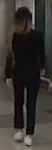

In [4]:
# 샘플 이미지 출력
from PIL import Image
im, kls, path = ds[2]
print(im.shape)
Image.open(path)

In [5]:
# 모델 로드
def load_model(model, model_path):
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_path)
    pretrained_dict = {k:v for k, v in pretrained_dict.items() if k in model_dict}
    no_model_keys = [k for k, _ in pretrained_dict.items() if k in model_dict]
    print('no_model_keys:', no_model_keys)

    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model


In [6]:
# 정확도 계산 유틸 함수
def cal_accuracy(y_score, y_true):
    y_score = np.asarray(y_score)
    y_true = np.asarray(y_true)
    best_acc = 0
    best_th = 0
    for i in range(len(y_score)):
        th = y_score[i]
        y_test = (y_score > th)
        acc = np.mean((y_test == y_true).astype(int))
        if acc > best_acc:
            best_acc = acc
            best_th = th

    return (best_acc, best_th)

In [10]:
# 학습된 모델 불러오기
import torch
from models import resnet50

model = resnet50()
model = load_model(model, weight_path)
model = model.to('cuda')
model = model.train(False)

load pretrained model
no_model_keys: []


In [11]:
# inference
from tqdm.auto import tqdm
ds = dataset.DataSet(BASE_DIR, test_imgs, phase='test')
dl = DataLoader(ds, num_workers=8, batch_size=32)
print(len(ds), len(dl))

# 임베딩값
total_embs = []

# 대응되는 경로
total_paths = []

# 대응되는 클래스 아이디
total_klss = []
for i, (ims, klss, paths) in enumerate(tqdm(dl)):
    ims = ims.to('cuda')
    with torch.no_grad():
        embs = model(ims).detach()
    total_embs.append(embs)
    total_paths.extend(paths)
    total_klss.append(klss)
total_embs= torch.cat(total_embs)
total_klss = torch.cat(total_klss)
total_embs.shape, total_klss.shape, len(total_paths)

119361 3731


  0%|          | 0/3731 [00:00<?, ?it/s]

(torch.Size([119361, 512]), torch.Size([119361]), 119361)

In [29]:
# 결과값을 DataFrame 형태로 정리
import pandas as pd
df = pd.DataFrame({
    'path':total_paths, 
    'kls':total_klss.cpu(), 
    'emb':list(total_embs.cpu())})
df

,path,kls,emb
0,/data/kts123/aihub/reid/val_imgs/OUT_H00933_SN...,909,"[tensor(-0.4067), tensor(1.0210), tensor(0.166..."
1,/data/kts123/aihub/reid/val_imgs/OUT_H00272_SN...,252,"[tensor(-0.8283), tensor(0.8893), tensor(1.996..."
2,/data/kts123/aihub/reid/val_imgs/OUT_H00157_SN...,138,"[tensor(-0.5044), tensor(-0.6650), tensor(-0.1..."
3,/data/kts123/aihub/reid/val_imgs/IN_H00870_SN3...,846,"[tensor(-2.1613), tensor(1.5503), tensor(1.964..."
4,/data/kts123/aihub/reid/val_imgs/IN_H00889_SN3...,865,"[tensor(-1.5020), tensor(0.1459), tensor(-0.61..."
...,...,...,...
119356,/data/kts123/aihub/reid/val_imgs/OUT_H00382_SN...,362,"[tensor(-0.6854), tensor(-0.5850), tensor(0.32..."
119357,/data/kts123/aihub/reid/val_imgs/IN_H00854_SN4...,830,"[tensor(-1.3758), tensor(-1.3641), tensor(1.62..."
119358,/data/kts123/aihub/reid/val_imgs/OUT_H00681_SN...,658,"[tensor(-0.6240), tensor(1.4484), tensor(0.677..."
119359,/data/kts123/aihub/reid/val_imgs/OUT_H00139_SN...,120,"[tensor(-1.3267), tensor(-0.9377), tensor(1.04..."


In [ ]:
total_paths